# Học nhúng ảnh đáy mắt với Triplet Loss
Notebook này hướng dẫn xây dựng pipeline học embedding cho ảnh đáy mắt bằng Triplet Loss, sử dụng EfficientNet-B3 làm backbone.

In [18]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b3

In [19]:
# Định nghĩa dataset Triplet
class TripletDRDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_to_indices = self.data.groupby('diagnosis').indices if hasattr(self.data.groupby('diagnosis'), 'indices') else self.data.groupby('diagnosis').groups
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        anchor_row = self.data.iloc[idx]
        anchor_img = Image.open(os.path.join(self.img_dir, anchor_row[0] + '.png')).convert('RGB')
        anchor_label = int(anchor_row[1])
        # Positive sample (cùng lớp)
        pos_idx = idx
        while pos_idx == idx:
            pos_idx = np.random.choice(self.label_to_indices[anchor_label])
        pos_row = self.data.iloc[pos_idx]
        pos_img = Image.open(os.path.join(self.img_dir, pos_row[0] + '.png')).convert('RGB')
        # Negative sample (khác lớp)
        neg_label = np.random.choice([l for l in self.label_to_indices.keys() if l != anchor_label])
        neg_idx = np.random.choice(self.label_to_indices[neg_label])
        neg_row = self.data.iloc[neg_idx]
        neg_img = Image.open(os.path.join(self.img_dir, neg_row[0] + '.png')).convert('RGB')
        if self.transform:
            anchor_img = self.transform(anchor_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        return anchor_img, pos_img, neg_img

In [20]:
# Transform cho embedding
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_csv = 'aptos2019/train_split.csv'
img_dir = 'aptos2019/train_images'
train_dataset = TripletDRDataset(train_csv, img_dir, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [21]:
# Định nghĩa mô hình embedding
class EmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.backbone = efficientnet_b3(weights=None)
        self.backbone.classifier[1] = nn.Linear(self.backbone.classifier[1].in_features, embedding_dim)
    def forward(self, x):
        return self.backbone(x)

In [22]:
# Triplet Loss
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, anchor, positive, negative):
        d_pos = torch.nn.functional.pairwise_distance(anchor, positive)
        d_neg = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.relu(d_pos - d_neg + self.margin)
        return loss.mean()

In [23]:
from PIL import Image
import numpy as np

In [16]:
# Huấn luyện embedding
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EmbeddingNet(embedding_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = TripletLoss(margin=1.0)
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for anchor, positive, negative in train_loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        optimizer.zero_grad()
        anchor_emb = model(anchor)
        pos_emb = model(positive)
        neg_emb = model(negative)
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * anchor.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}')

C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\3887553420.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anchor_img = Image.open(os.path.join(self.img_dir, anchor_row[0] + '.png')).convert('RGB')
C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\3887553420.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anchor_label = int(anchor_row[1])
C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\3887553420.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

Epoch 1/50 - Loss: 1.2230
Epoch 2/50 - Loss: 1.1519
Epoch 3/50 - Loss: 1.0291
Epoch 4/50 - Loss: 1.0121
Epoch 5/50 - Loss: 0.9973
Epoch 6/50 - Loss: 0.9014
Epoch 7/50 - Loss: 0.9350
Epoch 8/50 - Loss: 0.8381
Epoch 9/50 - Loss: 0.8282
Epoch 10/50 - Loss: 0.7475
Epoch 11/50 - Loss: 0.7118
Epoch 12/50 - Loss: 0.6607
Epoch 13/50 - Loss: 0.7807
Epoch 14/50 - Loss: 0.7101
Epoch 15/50 - Loss: 0.6735
Epoch 16/50 - Loss: 0.6094
Epoch 17/50 - Loss: 0.5860
Epoch 18/50 - Loss: 0.5297
Epoch 19/50 - Loss: 0.5472
Epoch 20/50 - Loss: 0.4799
Epoch 21/50 - Loss: 0.4229
Epoch 22/50 - Loss: 0.3544
Epoch 23/50 - Loss: 0.3928
Epoch 24/50 - Loss: 0.3388
Epoch 25/50 - Loss: 0.3368
Epoch 26/50 - Loss: 0.3065
Epoch 27/50 - Loss: 0.2730
Epoch 28/50 - Loss: 0.1858
Epoch 29/50 - Loss: 0.2566
Epoch 30/50 - Loss: 0.2800
Epoch 31/50 - Loss: 0.2591
Epoch 32/50 - Loss: 0.3560
Epoch 33/50 - Loss: 0.2976
Epoch 34/50 - Loss: 0.3422
Epoch 35/50 - Loss: 0.2245
Epoch 36/50 - Loss: 0.1396
Epoch 37/50 - Loss: 0.2345
Epoch 38/5

C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\606710966.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('triplet_embedding.pth'))
C:

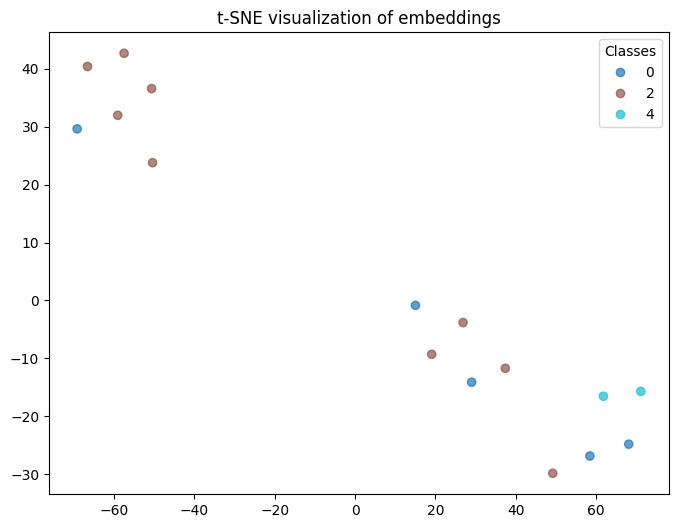

In [25]:
# Lưu lại model Triplet Loss sau khi train
torch.save(model.state_dict(), 'triplet_embedding.pth')

# Load lại model Triplet Loss khi cần sử dụng
model = EmbeddingNet(embedding_dim=128).to(device)
model.load_state_dict(torch.load('triplet_embedding.pth'))

# Trực quan hóa embedding bằng t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Lấy embedding và label từ một batch
model.eval()
with torch.no_grad():
    anchor, positive, negative = next(iter(train_loader))
    anchor = anchor.to(device)
    anchor_emb = model(anchor).cpu().numpy()
    labels = [int(l) for l in train_dataset.data.iloc[:anchor.shape[0], 1]]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
emb_2d = tsne.fit_transform(anchor_emb)

plt.figure(figsize=(8,6))
scatter = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title('t-SNE visualization of embeddings')
plt.show()

In [27]:
# Đánh giá accuracy embedding bằng k-NN với model đã save (dùng val_split.csv làm test)
class DRClassificationDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0] + '.png'
        label = int(self.data.iloc[idx, 1])
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Tạo dataset và dataloader cho train/test
train_dataset_cls = DRClassificationDataset('aptos2019/train_split.csv', 'aptos2019/train_images', transform)
test_dataset_cls = DRClassificationDataset('aptos2019/val_split.csv', 'aptos2019/train_images', transform)
train_loader_cls = DataLoader(train_dataset_cls, batch_size=32, shuffle=False)
test_loader_cls = DataLoader(test_dataset_cls, batch_size=32, shuffle=False)

# Load lại model đã save
model = EmbeddingNet(embedding_dim=128).to(device)
model.load_state_dict(torch.load('triplet_embedding.pth'))
model.eval()

# Trích xuất embedding và label cho train
train_embeddings, train_labels = [], []
with torch.no_grad():
    for images, labels in train_loader_cls:
        images = images.to(device)
        emb = model(images).cpu().numpy()
        train_embeddings.append(emb)
        train_labels.extend(labels.numpy())
train_embeddings = np.concatenate(train_embeddings, axis=0)

# Trích xuất embedding và label cho test
test_embeddings, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader_cls:
        images = images.to(device)
        emb = model(images).cpu().numpy()
        test_embeddings.append(emb)
        test_labels.extend(labels.numpy())
test_embeddings = np.concatenate(test_embeddings, axis=0)

# Đánh giá bằng k-NN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, train_labels)
preds = knn.predict(test_embeddings)
acc = accuracy_score(test_labels, preds)
print(f'Accuracy của embedding trên tập kiểm tra (k-NN, val_split.csv): {acc:.4f}')

C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\2486762293.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('triplet_embedding.pth'))


Accuracy của embedding trên tập kiểm tra (k-NN, val_split.csv): 0.7500


In [17]:
# Kiểm tra embedding: khoảng cách giữa các ảnh cùng lớp và khác lớp
import numpy as np
model.eval()
with torch.no_grad():
    anchor, positive, negative = next(iter(train_loader))
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)
    anchor_emb = model(anchor)
    pos_emb = model(positive)
    neg_emb = model(negative)
    d_pos = torch.nn.functional.pairwise_distance(anchor_emb, pos_emb)
    d_neg = torch.nn.functional.pairwise_distance(anchor_emb, neg_emb)
    print('Khoảng cách anchor-positive:', d_pos.cpu().numpy())
    print('Khoảng cách anchor-negative:', d_neg.cpu().numpy())

C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\3887553420.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anchor_img = Image.open(os.path.join(self.img_dir, anchor_row[0] + '.png')).convert('RGB')
C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\3887553420.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anchor_label = int(anchor_row[1])
C:\Users\binhd\AppData\Local\Temp\ipykernel_11008\3887553420.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by p

Khoảng cách anchor-positive: [ 2.0232656   2.5003211   0.15335122  0.32640013  2.2511125   2.0989816
  1.3485038   1.3315696   1.633931    0.9681665  20.613558    0.627355
  0.42920464  7.442268    1.2859613   1.6527269 ]
Khoảng cách anchor-negative: [1.877018  0.4039245 1.8693936 4.3816366 3.0973732 4.515834  2.8409703
 2.256331  4.252901  3.355557  5.0695233 4.506646  4.627208  4.4992304
 2.015409  4.043021 ]
